# SARIMA Class (using Auto-Arima method)

The purpose of this notebook is to describe the class but also compile test/train data. We can then take a look at which models are not performing as well as others (possible hyperparameter tuning).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
import statsmodels.api as sm
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, r2_score
import pickle


In [3]:
class auto_ARIMA_model:
    def __init__(self, country_name, years):
        self.country_name = country_name
        self.years = years
        self.df = pd.read_csv('cleanedDF_modelling.csv')
        self.modelling_df = pd.DataFrame()
        self.new_df = pd.DataFrame() #differenced df
        self.forecast_df = pd.DataFrame()
        self.diff = 1
        self.aic = 0
        self.mse = 0
        self.r2_score = 0
         
    def setup(self):
        self.df.rename(columns={"Unnamed: 0": "Year"}, inplace=True)
        self.df['Year'] = pd.to_datetime(self.df['Year'], errors='coerce', format='%Y')
        self.df.set_index('Year', inplace=True)
        self.df.sort_index(inplace=True)
        self.df = self.df.loc[(self.df.index < '2019') & (self.df.index > '1949')]
        self.df = self.df.filter(regex='^' + str(self.country_name)+ '_', axis=1)
        self.modelling_df = self.df.filter(regex='CO2$', axis=1)
        self.new_df = pd.DataFrame(index=self.df.index)
        self.stationary_columns()
        return self.modelling_df
         
    
    def stationary_columns(self):
        for col in self.modelling_df.columns:
            if adfuller(self.modelling_df[col])[1] < 0.01:
                self.new_df[str(col) + '_diff0'] = self.modelling_df[col]
                self.diff = 0 
            elif adfuller(self.modelling_df[col].diff(1).dropna())[1] < 0.01:
                self.new_df[str(col) + '_diff1'] = self.modelling_df[col].diff(1)
                self.diff = 1
            elif adfuller(self.modelling_df[col].diff(1).diff(1).dropna())[1] < 0.01:
                self.new_df[str(col) +'_diff2'] = self.modelling_df[col].diff(1).diff(1)
                self.diff = 2
            elif adfuller(self.modelling_df[col].diff(1).diff(1).diff(1).dropna())[1] < 0.01:
                self.new_df[str(col) +'_diff3'] = self.modelling_df[col].diff(1).diff(1).diff(1)
                self.diff= 3
            elif adfuller(self.modelling_df[col].diff(1).diff(1).diff(1).diff(1).dropna())[1] < 0.01:
                self.new_df[str(col) +'_diff4'] = self.modelling_df[col].diff(1).diff(1).diff(1).diff(1)
                self.diff = 4
            elif adfuller(self.modelling_df[col].diff(1).diff(1).diff(1).diff(1).diff(1).dropna())[1] < 0.01:
                self.new_df[str(col) +'_diff5'] = self.modelling_df[col].diff(1).diff(1).diff(1).diff(1).diff(1)
                self.diff = 5
        self.new_df = self.new_df.dropna()
        
    
    def train_model_fit(self): #refernce:https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
        steps = int(len(self.modelling_df)*0.75)
        train = self.modelling_df.iloc[0:steps]
        test = self.modelling_df.iloc[steps : len(self.modelling_df)]
        
        stepwise_model = auto_arima(self.modelling_df, start_p=1, start_q=1,max_p=3, max_q=3, m=12, start_P=0, seasonal=True,
                                    d=self.diff, D=1, trace=True, error_action='ignore',suppress_warnings=True, stepwise=True)
        
        self.aic = stepwise_model.aic()
        stepwise_model.fit(train)
        future_forecast = stepwise_model.predict(n_periods=len(test))
        self.forecast_df = pd.DataFrame(future_forecast, index = test.index, columns=[f'{self.country_name}' +'_CO2_prediction'])
        self.mse = mean_squared_error(test, future_forecast)
        self.r2_score = r2_score(test, future_forecast)
        print(f'Mean Squared Error {self.mse}')
        print(f'R2 Score {self.r2_score}')
        
        return self.forecast_df
    
    def model_fit(self): 
        
        stepwise_model = auto_arima(self.modelling_df, start_p=1, start_q=1,max_p=3, max_q=3, m=12, start_P=0, seasonal=True,
                                    d=self.diff, D=1, trace=True, error_action='ignore',suppress_warnings=True, stepwise=True)
        
        self.aic_total = stepwise_model.aic()
        stepwise_model.fit(self.modelling_df)
        
        pickle.dump(stepwise_model, open(f'{self.country_name}_SARIMA.p', 'wb'))
        
        future_forecast = stepwise_model.predict(n_periods=self.years)
        self.forecast_df = pd.DataFrame(future_forecast, index = pd.to_datetime([year for year in range(2019, 2019+self.years)],  errors='coerce', format='%Y'), columns=[f'{self.country_name}' +'_CO2_forecast'])
        return self.forecast_df

    
    def plot_results (self):

        fig, ax = plt.subplots (figsize = (5, 5))
        sns.lineplot(x = self.df.index.values, y= self.df[str(self.country_name)+'_CO2'])
        sns.lineplot(x = self.forecast_df.index.values, y= self.forecast_df[''.join(list(self.forecast_df.columns))])
        
        ax.set(xlabel='Date', ylabel ='CO2 Emissions', title = f'CO2 Emissions {self.country_name} (over time)')
        ax.get_xaxis().set_major_locator(mdates.AutoDateLocator())
         
        plt.setp(ax.get_xticklabels(), rotation=45)
        plt.show();
        
                
    def __del__(self):
        print("removing model")
    

In [4]:
Canada23 = auto_ARIMA_model('Canada', 20)

In [5]:
Canada23.setup()

,Canada_CO2
Year,
1950-01-01,154000.0
1951-01-01,163000.0
1952-01-01,160000.0
1953-01-01,161000.0
1954-01-01,163000.0
...,...
2014-01-01,578000.0
2015-01-01,577000.0
2016-01-01,565000.0


In [6]:
Canada21.stationary_columns()

NameError: name 'Canada21' is not defined

In [8]:
Canada23.train_model_fit()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1257.572, Time=0.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1263.709, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1258.330, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1256.505, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1261.590, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1255.501, Time=0.61 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1258.116, Time=0.14 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1261.972, Time=0.85 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1257.461, Time=1.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1256.677, Time=0.87 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1259.899, Time=0.61 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1258.591, Time=1.58 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1256.987, Time=0.93 sec
 ARIMA(0,1,2)(1,1,1)[12]

,Canada_CO2_prediction
Year,
2001-01-01,579351.157598
2002-01-01,580687.850409
2003-01-01,578508.124541
2004-01-01,590807.547847
2005-01-01,589454.006243
2006-01-01,600525.821798
2007-01-01,609669.217220
2008-01-01,623611.527341
2009-01-01,631762.817866


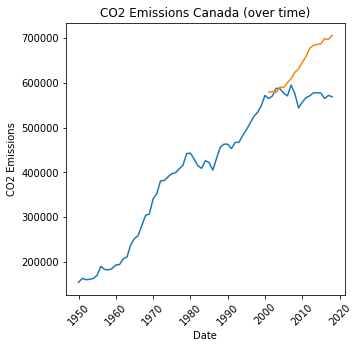

In [9]:
Canada23.plot_results()

In [16]:
country_df = pd.read_csv('cleanedDF_modelling.csv')
country_df = country_df.filter(regex='CO2$', axis=1)
country_df.columns = country_df.columns.str.rstrip('_CO2')
country_list = [col for col in country_df.columns]
countries = pd.DataFrame([country_list]).T
countries.rename(columns = {0: 'country_names'}, inplace=True)

In [17]:
countries['mse'] = 0.0
countries['r2_score'] = 0.0

In [18]:
countries = countries.set_index('country_names')

In [21]:
for index, row in countries.iterrows():
    try:
        country_name = str(index)
        country_name = auto_ARIMA_model(str(index), 20)
        country_name.setup()
        country_name.train_model_fit()
        row['mse'] = country_name.mse
        row['r2_score'] = country_name.r2_score

    except:
        pass

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=910.207, Time=0.43 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=919.123, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=907.295, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=909.796, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=910.682, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=909.085, Time=0.95 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=909.117, Time=0.39 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=908.209, Time=0.33 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=911.074, Time=2.01 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=915.787, Time=0.16 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=909.265, Time=0.37 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=909.272, Time=0.35 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=908.769, Time=0.30 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=911.145, Time=0.85 sec
 ARIMA(1,1,0)(1,1,0)[12] intercep

 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=1159.238, Time=0.03 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=1151.628, Time=0.09 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=1155.341, Time=0.04 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=1148.565, Time=0.28 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=1148.757, Time=1.56 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=inf, Time=1.34 sec
 ARIMA(0,2,0)(2,1,0)[12]             : AIC=1158.480, Time=0.27 sec
 ARIMA(2,2,0)(2,1,0)[12]             : AIC=1149.791, Time=0.40 sec
 ARIMA(1,2,1)(2,1,0)[12]             : AIC=1139.252, Time=0.81 sec
 ARIMA(1,2,1)(1,1,0)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(1,2,1)(2,1,1)[12]             : AIC=1140.757, Time=3.10 sec
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,2,1)(2,1,0)[12]             : AIC=1138.075, Time=0.87 sec
 ARIMA(0,2,1)(1,1,0)

 ARIMA(1,1,2)(1,1,1)[12]             : AIC=inf, Time=2.80 sec
 ARIMA(0,1,2)(2,1,0)[12]             : AIC=964.334, Time=3.06 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=969.990, Time=0.77 sec
 ARIMA(0,1,2)(2,1,1)[12]             : AIC=inf, Time=5.50 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=1.45 sec
 ARIMA(0,1,3)(2,1,0)[12]             : AIC=965.830, Time=2.51 sec
 ARIMA(1,1,3)(2,1,0)[12]             : AIC=inf, Time=7.10 sec
 ARIMA(0,1,2)(2,1,0)[12] intercept   : AIC=966.259, Time=2.82 sec

Best model:  ARIMA(0,1,2)(2,1,0)[12]          
Total fit time: 71.800 seconds
Mean Squared Error 24005556.083281547
R2 Score -265.44696859912096
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1011.349, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1009.188, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,1,0)[12]  

 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1163.326, Time=0.64 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1168.993, Time=0.15 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1164.056, Time=2.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1164.405, Time=0.97 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1162.781, Time=0.53 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1160.733, Time=0.37 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1166.324, Time=0.28 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1162.327, Time=0.60 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1161.872, Time=0.42 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1164.046, Time=2.50 sec
 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=1161.109, Time=1.08 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 11.795 seconds
Mean Squared Error 2180791517.0625525
R2 Score -13.81293593387221
removing model
Performing stepwise search to minimize ai

Mean Squared Error 103289071.35838991
R2 Score -9.627358795341499
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=829.304, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=835.710, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=825.188, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=827.375, Time=0.29 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=833.123, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=827.174, Time=0.72 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=827.179, Time=0.39 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=827.672, Time=0.27 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.81 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=828.781, Time=0.14 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=826.783, Time=0.33 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=826.763, Time=0.31 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=824.795, Time=0.20 sec
 ARIMA(0,1,1)(0,1,0)[1

 ARIMA(1,2,1)(1,1,2)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(0,2,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,2,0)(0,1,1)[12] intercept   : AIC=693.122, Time=0.43 sec
 ARIMA(2,2,1)(0,1,1)[12] intercept   : AIC=680.818, Time=1.45 sec
 ARIMA(1,2,2)(0,1,1)[12] intercept   : AIC=680.824, Time=0.95 sec
 ARIMA(0,2,0)(0,1,1)[12] intercept   : AIC=720.942, Time=0.37 sec
 ARIMA(0,2,2)(0,1,1)[12] intercept   : AIC=679.437, Time=0.99 sec
 ARIMA(2,2,0)(0,1,1)[12] intercept   : AIC=687.560, Time=0.56 sec
 ARIMA(2,2,2)(0,1,1)[12] intercept   : AIC=inf, Time=3.52 sec

Best model:  ARIMA(1,2,1)(0,1,1)[12] intercept
Total fit time: 25.357 seconds
Mean Squared Error 716347.5005375823
R2 Score 0.2414848340616449
removing model
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=559.526, Time=0.44 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=624.040, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=571.696, Time=0.22 sec
 ARIMA(0,2,1)(0,1,

Mean Squared Error 9766.63132147662
R2 Score 0.2188278504139224
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=567.400, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=550.833, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=567.926, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=548.990, Time=0.50 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=547.707, Time=0.31 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=550.167, Time=0.10 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=549.074, Time=0.49 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5

 ARIMA(0,1,3)(0,1,2)[12]             : AIC=1074.324, Time=1.46 sec
 ARIMA(0,1,3)(0,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(0,1,3)(1,1,2)[12]             : AIC=1076.475, Time=3.06 sec
 ARIMA(0,1,3)(1,1,1)[12]             : AIC=1087.316, Time=0.49 sec
 ARIMA(0,1,3)(0,1,2)[12] intercept   : AIC=1076.269, Time=2.76 sec

Best model:  ARIMA(0,1,3)(0,1,2)[12]          
Total fit time: 53.730 seconds
Mean Squared Error 101564394.31139807
R2 Score 0.5618184051293974
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=455.549, Time=0.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=464.353, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=463.529, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=455.676, Time=0.22 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=454.557, Time=0.18 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=455.670, Time=0.26 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(0,

 ARIMA(1,1,1)(2,1,0)[12] intercept   : AIC=960.947, Time=3.78 sec

Best model:  ARIMA(1,1,1)(2,1,0)[12]          
Total fit time: 40.899 seconds
Mean Squared Error 6959051.785664454
R2 Score -3.1739987714498765
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1011.374, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=992.826, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1013.200, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=987.139, Time=1.06 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=985.192, Time=0.66 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=991.173, Time=0.15 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.70 sec
 ARIMA(0,1,0)(1,1,1)[12

 ARIMA(3,1,0)(2,1,0)[12]             : AIC=577.492, Time=0.99 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=2.75 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=576.313, Time=0.88 sec
 ARIMA(3,1,1)(2,1,0)[12]             : AIC=579.456, Time=2.91 sec
 ARIMA(2,1,0)(2,1,0)[12] intercept   : AIC=577.562, Time=2.52 sec

Best model:  ARIMA(2,1,0)(2,1,0)[12]          
Total fit time: 20.900 seconds
Mean Squared Error 1685.6813949280202
R2 Score 0.7723071164945456
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=407.681, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=407.557, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=406.461, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=405.330, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=408.971, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=407.322, Time=0.33 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=407.322, Time=0.68 sec
 ARIMA(0,

 ARIMA(3,2,1)(0,1,1)[12]             : AIC=1142.121, Time=0.25 sec
 ARIMA(3,2,1)(0,1,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(3,2,1)(1,1,1)[12]             : AIC=1143.616, Time=0.79 sec
 ARIMA(3,2,1)(0,1,2)[12]             : AIC=1143.599, Time=0.56 sec
 ARIMA(3,2,1)(1,1,0)[12]             : AIC=1143.487, Time=0.32 sec
 ARIMA(3,2,1)(1,1,2)[12]             : AIC=1145.318, Time=0.96 sec
 ARIMA(3,2,2)(0,1,1)[12]             : AIC=1138.256, Time=0.42 sec
 ARIMA(3,2,2)(0,1,0)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(3,2,2)(1,1,1)[12]             : AIC=1139.833, Time=0.80 sec
 ARIMA(3,2,2)(0,1,2)[12]             : AIC=inf, Time=1.92 sec
 ARIMA(3,2,2)(1,1,0)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(3,2,2)(1,1,2)[12]             : AIC=1141.561, Time=1.46 sec
 ARIMA(2,2,2)(0,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(3,2,3)(0,1,1)[12]             : AIC=inf, Time=1.03 sec
 ARIMA(2,2,3)(0,1,1)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(3,2,2)(0,1,1)[12] inter

 ARIMA(0,2,1)(0,1,1)[12]             : AIC=823.438, Time=0.30 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=830.144, Time=0.05 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=825.355, Time=0.59 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=825.328, Time=0.65 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=826.279, Time=0.18 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,2,2)(0,1,1)[12]             : AIC=823.085, Time=0.31 sec
 ARIMA(0,2,2)(0,1,0)[12]             : AIC=831.797, Time=0.11 sec
 ARIMA(0,2,2)(1,1,1)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(0,2,2)(0,1,2)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(0,2,2)(1,1,0)[12]             : AIC=827.123, Time=0.25 sec
 ARIMA(0,2,2)(1,1,2)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=824.122, Time=0.58 sec
 ARIMA(0,2,3)(0,1,1)[12]             : AIC=824.798, Time=0.46 sec
 ARIMA(1,2,3)(0,1,1)[12]      

 ARIMA(1,2,1)(0,1,1)[12]             : AIC=473.253, Time=0.57 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=535.073, Time=0.03 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=495.948, Time=0.14 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=476.918, Time=0.34 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=483.259, Time=0.28 sec
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=474.839, Time=0.50 sec
 ARIMA(1,2,1)(0,1,2)[12]             : AIC=474.912, Time=0.85 sec
 ARIMA(1,2,1)(1,1,0)[12]             : AIC=474.949, Time=0.49 sec
 ARIMA(1,2,1)(1,1,2)[12]             : AIC=476.566, Time=1.50 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=495.556, Time=0.11 sec
 ARIMA(2,2,1)(0,1,1)[12]             : AIC=473.327, Time=0.37 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(0,2,2)(0,1,1)[12]             : AIC=471.201, Time=0.24 sec
 ARIMA(0,2,2)(0,1,0)[12]             : AIC=482.608, Time=0.05 sec
 ARIMA(0,2,2)(1,1,

Mean Squared Error 2041483297.500501
R2 Score -7.556799332343626
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=460.852, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=473.359, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=460.230, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=459.119, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=466.111, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=460.763, Time=0.23 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=460.909, Time=0.33 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=459.281, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=462.581, Time=0.63 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=465.621, Time=0.10 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=460.269, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=460.349, Time=0.10 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=457.545, Time=0.33 sec
 ARIMA(1,1,2)(0,1,0

 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=745.252, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=745.399, Time=2.22 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=739.604, Time=0.18 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=743.295, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=741.552, Time=0.18 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=738.959, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=754.344, Time=0.01 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=743.714, Time=0.31 sec
 ARIMA(0,1,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   :

 ARIMA(3,3,0)(1,1,0)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(3,3,2)(1,1,0)[12]             : AIC=1292.444, Time=1.19 sec
 ARIMA(3,3,2)(0,1,0)[12]             : AIC=1290.394, Time=0.39 sec
 ARIMA(3,3,2)(0,1,1)[12]             : AIC=1289.491, Time=0.79 sec
 ARIMA(3,3,2)(1,1,1)[12]             : AIC=1294.414, Time=1.06 sec
 ARIMA(3,3,2)(0,1,2)[12]             : AIC=1290.571, Time=2.11 sec
 ARIMA(3,3,2)(1,1,2)[12]             : AIC=1296.107, Time=3.54 sec
 ARIMA(2,3,2)(0,1,1)[12]             : AIC=1289.119, Time=0.44 sec
 ARIMA(2,3,2)(0,1,0)[12]             : AIC=1290.019, Time=0.51 sec
 ARIMA(2,3,2)(1,1,1)[12]             : AIC=1289.577, Time=1.53 sec
 ARIMA(2,3,2)(0,1,2)[12]             : AIC=1290.255, Time=1.59 sec
 ARIMA(2,3,2)(1,1,0)[12]             : AIC=1287.577, Time=0.79 sec
 ARIMA(2,3,2)(2,1,0)[12]             : AIC=1289.577, Time=2.60 sec
 ARIMA(2,3,2)(2,1,1)[12]             : AIC=1291.565, Time=5.70 sec
 ARIMA(1,3,2)(1,1,0)[12]             : AIC=1313.612, Time=0.26 sec


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=937.200, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=949.850, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=936.929, Time=0.68 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=936.085, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=937.241, Time=0.23 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.21 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=937.360, Time=0.58 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=937.498, Time=0.56 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 9.259 seconds
Mean Squared Error 22243166.221348707
R2 Score -10.03022797101748
removing model
Perform

 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=1155.905, Time=0.24 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=1154.904, Time=0.13 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1172.310, Time=0.04 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=1155.935, Time=0.33 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1158.487, Time=0.14 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=1157.903, Time=0.65 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=1154.891, Time=0.18 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=1171.366, Time=0.06 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=1156.030, Time=0.26 sec
 ARIMA(3,1,0)(0,1,2)[12]             : AIC=1156.050, Time=0.46 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=1159.165, Time=0.19 sec
 ARIMA(3,1,0)(1,1,2)[12]             : AIC=1158.029, Time=0.82 sec
 ARIMA(3,1,1)(0,1,1)[12]             : AIC=1157.035, Time=0.45 sec
 ARIM

 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.12 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=775.143, Time=0.45 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=781.361, Time=0.09 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=777.036, Time=0.67 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=775.700, Time=1.21 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 15.265 seconds
Mean Squared Error 3409759.8166163405
R2 Score -50.11019419502364
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=808.377, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=796.075, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]     

 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=793.500, Time=1.10 sec
 ARIMA(0,1,1)(2,1,0)[12] intercept   : AIC=793.542, Time=0.63 sec
 ARIMA(1,1,1)(2,1,0)[12] intercept   : AIC=795.510, Time=1.85 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12] intercept
Total fit time: 13.498 seconds
Mean Squared Error 547284.2405624418
R2 Score 0.4085886216332274
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=666.424, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=668.557, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=667.735, Time=0.20 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=666.865, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=666.076, Time=0.26 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=667.528, Time=0.54 sec
 ARIMA(0,1,0)(1,1,

 ARIMA(0,2,1)(2,1,0)[12] intercept   : AIC=638.824, Time=1.63 sec
 ARIMA(0,2,1)(1,1,0)[12] intercept   : AIC=643.479, Time=0.60 sec
 ARIMA(0,2,1)(2,1,1)[12] intercept   : AIC=639.700, Time=2.81 sec
 ARIMA(0,2,1)(1,1,1)[12] intercept   : AIC=638.970, Time=0.62 sec
 ARIMA(0,2,0)(2,1,0)[12] intercept   : AIC=660.239, Time=0.88 sec
 ARIMA(1,2,1)(2,1,0)[12] intercept   : AIC=640.704, Time=1.97 sec
 ARIMA(0,2,2)(2,1,0)[12] intercept   : AIC=640.754, Time=1.36 sec
 ARIMA(1,2,0)(2,1,0)[12] intercept   : AIC=644.675, Time=0.92 sec
 ARIMA(1,2,2)(2,1,0)[12] intercept   : AIC=640.681, Time=2.39 sec

Best model:  ARIMA(0,2,1)(2,1,0)[12] intercept
Total fit time: 28.549 seconds
Mean Squared Error 589191.6574259481
R2 Score 0.34614119855421854
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=765.873, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=763.351, Time=0.14 sec
 ARIMA(0,

 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=994.040, Time=0.05 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=964.679, Time=0.59 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=981.775, Time=0.04 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=957.314, Time=1.82 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=inf, Time=2.65 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,2,0)(2,1,0)[12]             : AIC=974.672, Time=0.63 sec
 ARIMA(2,2,0)(2,1,0)[12]             : AIC=957.123, Time=0.96 sec
 ARIMA(2,2,0)(1,1,0)[12]             : AIC=963.341, Time=0.32 sec
 ARIMA(2,2,0)(2,1,1)[12]             : AIC=inf, Time=1.81 sec
 ARIMA(2,2,0)(1,1,1)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(3,2,0)(2,1,0)[12]             : AIC=958.998, Time=1.21 sec
 ARIMA(2,2,1)(2,1,0)[12]             : AIC=959.076, Time=2.14 sec
 ARIMA(1,2,1)(2,1,0)[12]          

 ARIMA(1,1,2)(1,1,1)[12]             : AIC=904.712, Time=0.92 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=904.639, Time=1.92 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=903.849, Time=0.53 sec
 ARIMA(1,1,2)(1,1,2)[12]             : AIC=inf, Time=2.16 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=905.133, Time=0.67 sec
 ARIMA(1,1,3)(0,1,1)[12]             : AIC=905.120, Time=0.56 sec
 ARIMA(0,1,3)(0,1,1)[12]             : AIC=903.103, Time=0.41 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=903.950, Time=0.64 sec
 ARIMA(2,1,3)(0,1,1)[12]             : AIC=906.434, Time=1.15 sec
 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=904.015, Time=0.78 sec

Best model:  ARIMA(1,1,2)(0,1,1)[12]          
Total fit time: 17.080 seconds
Mean Squared Error 9842183.497925105
R2 Score -0.5460980629227141
removing model
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=962.467, Time=0.62 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=991.523, Time=0.02 sec
 ARIMA(1,

 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1205.887, Time=0.21 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1210.310, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1207.907, Time=0.36 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1204.490, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1202.696, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1219.293, Time=0.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1204.683, Time=0.18 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1204.681, Time=0.20 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=1206.696, Time=0.39 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=1203.562, Time=0.12 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1206.132, Time=0.35 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=1203.422, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 3.054 seconds
Mean Squared Error 811527051.1920505
R2 Score -16.851501

 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1261.945, Time=0.32 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1267.332, Time=0.06 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1263.845, Time=0.72 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1262.887, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1258.715, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1272.878, Time=0.02 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1260.707, Time=0.17 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1260.705, Time=0.28 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=1262.596, Time=0.69 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=1260.121, Time=0.22 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1262.920, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=1260.040, Time=0.20 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 4.112 seconds
Mean Squared Error 1740506268.1850252
R2 Score -3.561921

 ARIMA(0,1,0)(2,1,0)[12]             : AIC=552.078, Time=0.49 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=558.178, Time=0.08 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=554.047, Time=0.68 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=555.990, Time=1.05 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=553.693, Time=1.00 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 7.388 seconds
Mean Squared Error 49455.067079998174
R2 Score -350.2988190370825
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=812.081, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=787.863, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=814.080, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[1

 ARIMA(2,1,2)(1,1,0)[12] intercept   : AIC=789.405, Time=1.01 sec
 ARIMA(1,1,3)(1,1,0)[12] intercept   : AIC=788.968, Time=0.94 sec
 ARIMA(0,1,3)(1,1,0)[12] intercept   : AIC=788.629, Time=0.68 sec
 ARIMA(2,1,1)(1,1,0)[12] intercept   : AIC=792.739, Time=0.88 sec
 ARIMA(2,1,3)(1,1,0)[12] intercept   : AIC=789.452, Time=1.11 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=787.760, Time=0.66 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=804.002, Time=0.17 sec
 ARIMA(1,1,2)(2,1,0)[12]             : AIC=788.773, Time=0.98 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=788.896, Time=0.72 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=788.996, Time=0.77 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=790.770, Time=1.79 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=791.772, Time=0.62 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=2.07 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=789.358, Time=1.09 sec
 ARIMA(1,1,3)(1,1,0)[12]             : AIC=789.253, Time=0.76 sec
 ARIMA(0,1,1)(

 ARIMA(3,2,1)(2,1,1)[12]             : AIC=1046.615, Time=2.59 sec
 ARIMA(2,2,0)(2,1,1)[12] intercept   : AIC=1047.281, Time=1.56 sec

Best model:  ARIMA(2,2,0)(2,1,1)[12]          
Total fit time: 21.144 seconds
Mean Squared Error 2926025270.9352756
R2 Score -51.312468528498535
removing model
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=1153.844, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=1133.450, Time=0.08 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=1135.806, Time=0.03 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=1130.775, Time=0.28 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=1130.943, Time=0.39 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=1130.081, Time=0.15 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=1128.266, Time=0.10 sec
 ARIMA(1,2,0)(0,1,2)[12]             : AIC=1129.851, Time=0.27 sec
 A

 ARIMA(0,1,0)(2,1,1)[12]             : AIC=423.498, Time=0.58 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.72 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=425.473, Time=0.79 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=427.472, Time=0.88 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.44 sec

Best model:  ARIMA(0,1,0)(2,1,1)[12]          
Total fit time: 10.085 seconds
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=345.479, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=334.139, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=342.644, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=311.312, Time=0.33 sec
 ARIMA(1,1,0)(2,1,1)[12]     

 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=646.730, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=647.388, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=641.881, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=648.717, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=647.450, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.84 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=640.088, Time=0.14 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=645.522, Time=0.08 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.00 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=641.704, Time=0.23 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   :

 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=737.288, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=716.228, Time=0.63 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=729.092, Time=0.35 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=714.764, Time=0.64 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=724.672, Time=0.21 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.92 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=706.264, Time=0.76 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=716.978, Time=0.26 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(3,1,1)(2,1,0)[12]             : AIC=inf, Time=1.75 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC

 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1230.028, Time=0.13 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1232.043, Time=0.52 sec
 ARIMA(1,1,1)(1,1,0)[12] intercept   : AIC=1232.006, Time=0.30 sec

Best model:  ARIMA(1,1,1)(1,1,0)[12]          
Total fit time: 4.643 seconds
Mean Squared Error 6323017672.284228
R2 Score -2.989130239543753
removing model
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=905.953, Time=0.50 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=931.237, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=918.644, Time=0.26 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=904.324, Time=0.32 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=908.459, Time=0.09 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=905.970, Time=0.60 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=906.098, Time=0.89 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=904.001, Time=0.39 sec
 ARIMA(0,2,1)(2,1,0)[12]             : AIC=905.995, Time=0.90 sec
 ARI

 ARIMA(0,1,2)(0,1,2)[12]             : AIC=920.297, Time=0.78 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=919.853, Time=0.28 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=922.209, Time=1.15 sec
 ARIMA(0,1,3)(0,1,1)[12]             : AIC=919.848, Time=0.62 sec
 ARIMA(1,1,3)(0,1,1)[12]             : AIC=921.374, Time=1.09 sec
 ARIMA(0,1,2)(0,1,1)[12] intercept   : AIC=917.977, Time=0.40 sec
 ARIMA(0,1,2)(0,1,0)[12] intercept   : AIC=922.040, Time=0.06 sec
 ARIMA(0,1,2)(1,1,1)[12] intercept   : AIC=919.400, Time=0.88 sec
 ARIMA(0,1,2)(0,1,2)[12] intercept   : AIC=919.206, Time=1.19 sec
 ARIMA(0,1,2)(1,1,0)[12] intercept   : AIC=919.914, Time=0.32 sec
 ARIMA(0,1,2)(1,1,2)[12] intercept   : AIC=921.164, Time=1.24 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=924.229, Time=0.44 sec
 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=919.723, Time=0.50 sec
 ARIMA(0,1,3)(0,1,1)[12] intercept   : AIC=919.762, Time=0.55 sec
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=923.504, Time=0.44 sec
 ARIMA(1,1

 ARIMA(1,3,0)(1,1,0)[12]             : AIC=887.811, Time=0.28 sec
 ARIMA(0,3,1)(0,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(1,3,0)(0,1,0)[12]             : AIC=903.667, Time=0.04 sec
 ARIMA(1,3,0)(2,1,0)[12]             : AIC=889.748, Time=0.61 sec
 ARIMA(1,3,0)(1,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(1,3,0)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,3,0)(2,1,1)[12]             : AIC=inf, Time=1.38 sec
 ARIMA(0,3,0)(1,1,0)[12]             : AIC=930.536, Time=0.08 sec
 ARIMA(2,3,0)(1,1,0)[12]             : AIC=863.738, Time=0.45 sec
 ARIMA(2,3,0)(0,1,0)[12]             : AIC=880.274, Time=0.05 sec
 ARIMA(2,3,0)(2,1,0)[12]             : AIC=865.687, Time=1.19 sec
 ARIMA(2,3,0)(1,1,1)[12]             : AIC=864.790, Time=0.56 sec
 ARIMA(2,3,0)(0,1,1)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(2,3,0)(2,1,1)[12]             : AIC=inf, Time=2.32 sec
 ARIMA(3,3,0)(1,1,0)[12]             : AIC=865.641, Time=0.42 sec
 ARIMA(2,3,1)(1,1,0)[12]          

 ARIMA(1,2,0)(2,1,0)[12]             : AIC=1048.251, Time=0.26 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,2,0)(2,1,0)[12]             : AIC=1059.455, Time=0.19 sec
 ARIMA(2,2,0)(2,1,0)[12]             : AIC=1025.800, Time=1.09 sec
 ARIMA(2,2,0)(1,1,0)[12]             : AIC=1032.646, Time=0.17 sec
 ARIMA(2,2,0)(2,1,1)[12]             : AIC=inf, Time=1.82 sec
 ARIMA(2,2,0)(1,1,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(3,2,0)(2,1,0)[12]             : AIC=1023.948, Time=1.38 sec
 ARIMA(3,2,0)(1,1,0)[12]             : AIC=1029.278, Time=0.44 sec
 ARIMA(3,2,0)(2,1,1)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(3,2,0)(1,1,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(3,2,1)(2,1,0)[12]             : AIC=1023.720, Time=1.78 sec
 ARIMA(3,2,1)(1,1,0)[12]             : AIC=1028.275, Time=1.06 sec
 ARIMA(3,2,1)(2,1,1)[12]             : AIC=inf, Time=2.54 sec
 ARIMA(3,2,1)(1,1,1)[12]      

 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=212.308, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 8.428 seconds
Mean Squared Error 48.129969050718024
R2 Score -18.790172818784825
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=750.629, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=729.049, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=732.434, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=731.374, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=723.577, Time=0.45 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=725.516, Time=0.77 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=750.222, Time=0.26 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=725.036, Time=0.60 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=724.623, Time=0.90 sec
 ARIMA(0,1,1)

 ARIMA(0,1,0)(1,1,1)[12]             : AIC=904.791, Time=0.39 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=903.940, Time=0.46 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=905.939, Time=0.96 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=905.815, Time=1.32 sec
 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=905.931, Time=0.84 sec

Best model:  ARIMA(0,1,0)(0,1,2)[12]          
Total fit time: 9.734 seconds
Mean Squared Error 3474718.937418016
R2 Score -1.6408941148346727
removing model
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1143.083, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1135.872, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1134.088, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1144.750, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1131.132, Time=0.53 sec
 ARIMA(0,

 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1051.092, Time=0.77 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.78 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1048.725, Time=0.28 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1051.786, Time=0.39 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=1051.650, Time=2.23 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1050.724, Time=2.49 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1049.093, Time=1.56 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1049.638, Time=0.38 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=2.90 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1050.698, Time=0.34 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1051.803, Time=0.74 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=1050.846, Time=0.53 sec

Best model:  ARIMA(0,1,0)(1,1,1)[12]          
Total fit time: 23.652 seconds
Mean Squared Error 30087444.858977452
R2 Score -0.299112472321996

In [22]:
countries.head()

,mse,r2_score
country_names,,
Afghanistan,5.247080e+07,-2.393977
Albania,3.764656e+06,-12.600015
Algeria,5.693973e+08,-0.084022
Andorra,4.088031e+05,-342.313885
Angola,2.305565e+08,-1.597012
